In [237]:
from collections import defaultdict
from dnadb import fasta, sample
from numba import njit
import numpy as np
import tensorflow as tf
import tf_utilities as tfu
import settransformer as st
import wandb

from deepdna.nn.data_generators import SequenceGenerator
from deepdna.nn.layers import SplitClassToken
from deepdna.nn.models import load_model, setbert

In [2]:
%load_ext cython

In [3]:
tfu.devices.select_gpu(1)

2023-07-11 18:37:33.622325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 18:37:33.622614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 18:37:33.629557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 18:37:33.629796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 18:37:33.629974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')])

In [4]:
api = wandb.Api()

In [5]:
path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v2").download()
model = load_model(path, setbert.SetBertPretrainModel).base

wandb: Downloading large artifact setbert-pretrain-walker-abund-128d-250l:v2, 91.05MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.1
2023-07-11 18:37:39.695007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 18:37:39.697763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 18:37:39.698133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 18:37:39.698406: I tensorflow/stream_exe

In [6]:
classifier = setbert.SetBertEncoderModel(model)

In [209]:
samples = sample.load_multiplexed_fasta(
    "/home/dwl2x/work/Datasets/Walker_Alex/alex.fasta.db",
    "/home/dwl2x/work/Datasets/Walker_Alex/alex.fasta.mapping.db",
    "/home/dwl2x/work/Datasets/Walker_Alex/alex.fasta.index.db"
)
len(samples)

737

In [12]:
x = tf.stop_gradient(model.dnabert_encoder.encode(gen[0][0]))

2023-07-11 18:37:54.036278: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [8]:
def find_mha_layers(model):
    result = []
    for layer in model.layers:
        if isinstance(layer, st.SetAttentionBlock):
            result.append(layer.att)
        elif isinstance(layer, st.InducedSetAttentionBlock):
            result.append(layer.mab2.att)
        elif isinstance(layer, st.InducedSetEncoder):
            result.append(layer.mab.att)
        elif isinstance(layer, tf.keras.Model):
            result += find_mha_layers(layer)
    return result

In [46]:
def compute_attention_attribution_factory(call):
    @tf.function
    def compute_attention_attribution(x, mha_layers, integration_steps=20):
        # Initialize attention attribution weights
        for layer in mha_layers:
            layer.enable_attribution()
            layer._alpha.assign([1.0]*layer.num_heads)
        # Get the gradient shapes using a single call
        shapes = []
        _, scores = call(x)
        for layer_scores in scores: # [batch_index, head_index, n, n]
            batch_size = tf.shape(layer_scores)[0]
            n = tf.shape(layer_scores)[2]
            shapes.append((batch_size, n, n))
        # Compute attribution scores
        attrs = []
        for layer_index, layer in enumerate(mha_layers):
            attrs.append([])
            for head in range(layer.num_heads):
                grad_sum = tf.zeros(shapes[layer_index])
                for alpha in tf.linspace(0.0, 1.0, integration_steps):
                    layer.set_head_attribution_weight(head, alpha)
                    with tf.GradientTape() as tape:
                        y_pred, scores = call(x)
                    grads = tape.gradient(y_pred, scores[layer_index])[:,head,:,:]
                    grad_sum += grads
                attr_h = scores[layer_index][:,head,:,:]/integration_steps * grad_sum
                attrs[-1].append(attr_h)
        attrs = tf.transpose(attrs, (2, 0, 1, 3, 4))
        # attrs.shape == [sample_index, layer_index, head_index, n, n]
        return attrs
    return compute_attention_attribution

In [258]:
@njit
def compute_token_attributions(attrs_by_layer):
    """
    Compute the attribution scores by token.
    """
    num_tokens = attrs_by_layer.shape[-1]
    attr_all = np.zeros(num_tokens)
    for i in range(num_tokens):
        for l in range(attrs_by_layer.shape[0]):
            for j in range(num_tokens):
                if j == i:
                    continue
                attr_all[i] += attrs_by_layer[l,i,j]
    return attr_all

In [9]:
mha_layers = find_mha_layers(classifier.model)
len(mha_layers)

8

In [47]:
def call(x):
    return classifier(x, training=False, return_attention_scores=True, compute_sequence_embeddings=False)
compute_attention_attribution = compute_attention_attribution_factory(call)

In [243]:
def subsample_generator(samples, num_subsamples, subsample_size):
    for s in samples:
        gen = SequenceGenerator([s], sequence_length=250, kmer=3, batch_size=1, batches_per_epoch=num_subsamples, subsample_size=subsample_size)
        for i in range(num_subsamples):
            _, sequence_ids, x, _ = gen.get(i)
            x = tf.stop_gradient(model.dnabert_encoder.encode(x))
            yield sequence_ids[0], x[0]

In [294]:
def merged_attention_attribution(data_generator, call, mha_layers, integration_steps=20, tau=0.4):
    from graphviz import Digraph

    # Create the compute_attention_attribution function to gather attribution scores for each layer/head
    compute_attention_attribution = compute_attention_attribution_factory(call)

    token_ids = {}
    token_total_attrs = defaultdict(float)
    top_node = None
    top_node_value = -np.inf

    taus = [tau]*(len(mha_layers) - 1) + [0.0]
    edges_by_layer = [set() for _ in range(len(taus))]

    n = 0
    for (token_names, x) in data_generator:
        # Ensure token names have a corresponding ID
        for token_name in token_names:
            if token_name not in token_ids:
                token_ids[token_name] = len(token_ids)
        # attrs = compute_attention_attribution(x, mha_layers)
        attrs_by_layer = np.sum(attrs, axis=2)[0,:,1:,1:] # strip off class tokens
        token_attrs = compute_token_attributions(attrs_by_layer)

        # Sum up total attribution for each token
        for i, value in enumerate(token_attrs):
            token_total_attrs[token_ids[token_names[i]]] += value

        # Update the top node
        if np.max(token_attrs) > top_node_value:
            top_node = token_ids[token_names[np.argmax(token_attrs)]]

        # Create tree adges
        for l, (tau, edges) in enumerate(zip(taus, edges_by_layer)):
            a_ij = attrs_by_layer[l]
            max_attr_l = np.max(attrs_by_layer[l])
            for (i, j) in np.argwhere(a_ij/max_attr_l > tau):
                i_name = token_names[i]
                j_name = token_names[j]
                if i_name not in token_ids:
                    token_ids[i_name] = len(token_ids)
                if j_name not in token_ids:
                    token_ids[j_name] = len(token_ids)
                i_universal = token_ids[i_name]
                j_universal = token_ids[j_name]
                edges.add((i_universal, j_universal))

        n += 1
        break

    NotAppear, Appear, Fixed = "NotAppear", "Appear", "Fixed"
    state = {id: NotAppear for id in token_ids.values()}
    state[top_node] = Appear
    edges = set()
    vertices = set([top_node])
    for l in range(len(taus) - 2, -1, -1):
        for (i, j) in edges_by_layer[l]:
            if i == j:
                continue
            if state[i] is Appear and state[j] is NotAppear:
                edges.add((i, j))
                vertices.add(j)
                state[i] = Fixed
                state[j] = Appear
            if state[i] is Fixed and state[j] is NotAppear:
                edges.add((i, j))
                vertices.add(j)
                state[j] = Appear

    # Inject class token identifier
    vertices.add(-1)
    for j in range(len(state) - 1, -1, -1):
        if state[j] in (Appear, Fixed):
            edges.add((-1, j))

    # Create the tree graphic
    tree = Digraph()
    for vertex in vertices:
        tree.node(str(vertex + 1))
    tree.edges([(str(j+1), str(i+1)) for (i, j) in edges])
    tree.graph_attr["rankdir"] = "BT"

    # Compute the reversed ID map
    token_id_reverse_map = {v: k for k, v in token_ids.items()}
    token_id_reverse_map[-1] = "[CLS]"

    return token_id_reverse_map, token_total_attrs, tree

_ = merged_attention_attribution(subsample_generator(samples, 10, 1000), call, mha_layers)

/tmp/ipykernel_2163063/2767443049.py:37: RuntimeWarning: invalid value encountered in true_divide
  for (i, j) in np.argwhere(a_ij/max_attr_l > tau):


### Compute the raw attribution scores.

In [120]:
%%time
# attrs = compute_attention_attribution(mha_layers, lambda: model(x, training=False, return_attention_scores=True))
attrs = compute_attention_attribution(x, mha_layers)

CPU times: user 13.9 s, sys: 3.52 s, total: 17.4 s
Wall time: 15.2 s


### Compute the attribution scores by layer

In [182]:
attrs_by_layer = np.sum(attrs, axis=2)[:,:,1:,1:]
attrs_by_layer.shape

(1, 8, 1000, 1000)

### Compute the token attribution scores

In [183]:
attr_all = compute_token_attributions(attrs_by_layer)
attr_all.shape

(1, 1000)

### Build the Tree

In [184]:
token_ids = {}

In [185]:
token_names = [batch for batch in gen.get(0)[1]]

In [186]:
top_node = np.argmax(attr_all)
top_node_name = token_names[0][top_node]
if top_node_name not in token_ids:
    token_ids[top_node_name] = len(token_ids)
top_node = token_ids[top_node_name]
top_node

0

In [187]:
taus = [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.0] # use 0.0 for last layer for reasons discussed in paper
edges_l = [set() for _ in range(len(taus))]
for l in range(attrs_by_layer.shape[1]):
    tau = taus[l]
    a_ij = attrs_by_layer[0][l]
    max_attr_l = np.max(attrs_by_layer[0][l])
    edges = edges_l[l]
    for (i, j) in np.argwhere(a_ij/max_attr_l > tau):
        i_name = token_names[0][i]
        j_name = token_names[0][j]
        if i_name not in token_ids:
            token_ids[i_name] = len(token_ids)
        if j_name not in token_ids:
            token_ids[j_name] = len(token_ids)
        i_universal = token_ids[i_name]
        j_universal = token_ids[j_name]
        edges.add((i_universal, j_universal))
    # edges = set(map(tuple, np.argwhere(a_ij/max_attr_l > tau)))
    # print(edges)
# edges_l

/tmp/ipykernel_2163063/859207844.py:8: RuntimeWarning: invalid value encountered in true_divide
  for (i, j) in np.argwhere(a_ij/max_attr_l > tau):


In [188]:
NotAppear = "NotAppear"
Appear = "Appear"
Fixed = "Fixed"

In [190]:
state = {id: NotAppear for id in token_ids.values()}
len(state)

98

In [191]:
edges = set()
vertices = set([top_node])

state[top_node] = Appear

for l in range(attrs_by_layer.shape[1] - 2, -1, -1):
    for (i, j) in edges_l[l]:
        if i == j:
            continue
        if state[i] is Appear and state[j] is NotAppear:
            edges.add((i, j))
            vertices.add(j)
            state[i] = Fixed
            state[j] = Appear
        if state[i] is Fixed and state[j] is NotAppear:
            edges.add((i, j))
            vertices.add(j)
            state[j] = Appear

In [192]:
len(state)

98

In [193]:
# Inject class token identifier
vertices.add(-1)
vertices

{-1, 0, 2, 3, 4, 29, 32, 47, 50, 60, 68, 69, 70, 71, 74, 75, 77, 79, 80, 81}

In [200]:
for j in range(len(state) - 1, -1, -1):
    if state[j] in (Appear, Fixed):
        edges.add((-1, j))
len(edges)

37

In [202]:
from graphviz import Digraph
from IPython.display import display

In [204]:
tree = Digraph()
for vertex in vertices:
    tree.node(str(vertex + 1))
tree.edges([(str(j+1), str(i+1)) for (i, j) in edges])
tree.graph_attr["rankdir"] = "BT"

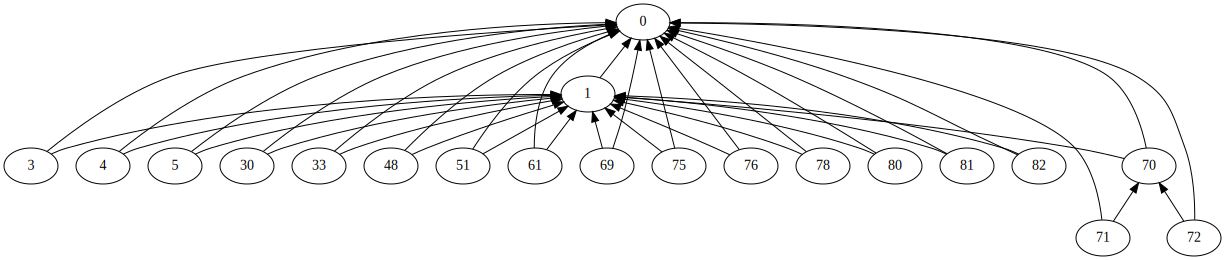

In [205]:
display(tree)